In [13]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

Define Agent

In [3]:
class PlannerState(TypedDict):
    messages : Annotated[List[HumanMessage | AIMessage], "The messages in conversation"]
    city : str
    interests : List[str]
    itenerary : str

In [7]:
groq_api_key = os.getenv("GROQ_API_KEY")

In [8]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=0,
    groq_api_key = groq_api_key,
    model="llama-3.3-70b-versatile"
)

In [11]:
response = llm.invoke("What is LLM?")
print(response.content)

LLM stands for Large Language Model. It refers to a type of artificial intelligence (AI) designed to process and understand human language at a large scale. LLMs are trained on vast amounts of text data, which enables them to learn patterns, relationships, and structures of language, allowing them to generate human-like text, answer questions, and even converse with humans.

LLMs are typically based on deep learning architectures, such as transformer models, and are trained using massive datasets of text from various sources, including books, articles, research papers, and websites. This training allows LLMs to develop a broad understanding of language, including grammar, syntax, semantics, and pragmatics.

Some key features of LLMs include:

1. **Language understanding**: LLMs can comprehend and interpret human language, including nuances and context.
2. **Text generation**: LLMs can generate coherent and natural-sounding text, often indistinguishable from human-written text.
3. **Con

In [14]:
itenerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

### Define Agent Functions

In [15]:
def input_city(state: PlannerState) -> PlannerState:
    print("Enter city name that you want to visit")
    user_message = input("Your input: ")
    return {
        **state,
        "city" : user_message,
        "messages" : state['messages'] + [HumanMessage(content=user_message)]
    }

def input_interest(state : PlannerState) -> PlannerState:
    print(f"Enter your interests for trip to {state['city']} (comma-separated)")
    user_message = input("Your input: ")
    return {
        **state,
        "interests" : [interest.strip() for interest in user_message.split(',')],
        "messages" : state['messages'] + [HumanMessage(content=user_message)]
    }
def create_itenerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itenerary for {state['city']} based on your interests : {', '.join(state['interests'])}"),
    response = llm.invoke(itenerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
    print("Finalised Itinerary: ")
    print(response.content)
    return {
        **state,
        "messages" : state['messages'] + [AIMessage(content = response.content)],
        "itinerary" : response.content
    }


#### Create an compile the Graph

In [16]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itenerary", create_itenerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itenerary")
workflow.add_edge("create_itenerary", END)

app = workflow.compile()

Display the graph

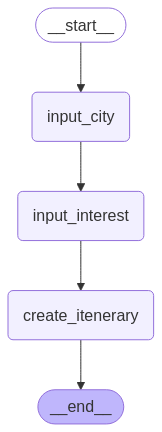

In [17]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method= MermaidDrawMethod.API
        )
    )
)

Define a function to run the graph 

In [18]:
def travel_planner(user_request: str):
    print(f"Initial request: {user_request}\n")
    state = {
        "messages" : [HumanMessage(content = user_request)],
        "city" : "",
        "interests" : [],
        "itinerary" : "",
    }

    for output in app.stream(state):
        pass

In [19]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial request: I want to plan a day trip

Enter city name that you want to visit
Enter your interests for trip to Paris (comma-separated)
Creating an itenerary for Paris based on your interests : Eiffel Tower, Church, Museum
Finalised Itinerary: 
For your day trip to Paris, here's a suggested itinerary based on your interests in the Eiffel Tower, a Church, and a Museum:

* 9:00 AM - Start the day with a visit to the iconic **Eiffel Tower** for breathtaking views of the city.
* 11:00 AM - Head to the historic **Notre-Dame Cathedral**, a beautiful and famous church in the heart of Paris.
* 1:00 PM - Take a break for lunch at a nearby café or restaurant.
* 2:30 PM - Visit the **Louvre Museum**, one of the world's largest and most famous museums, to explore its vast collection of art and artifacts.
* 5:00 PM - End the day with a scenic stroll along the Seine River, taking in the city's charm and beauty.

This itinerary provides a good balance of iconic landmarks, cultural experiences, an